# _feature engineering_ 


Um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.


## _Setup_ geral

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler
)

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_digits, fetch_20newsgroups
from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)

In [9]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [39]:
countries = pd.read_csv("countries.csv")

In [40]:
countries.head(5)

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisava de alguns ajustes iniciais. 
1. Notemos que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Vamos  corrigir isso antes de continuarmos e transformaremos essas variáveis em numéricas adequadamente.


2. Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Assim, pode utilizar o método `str.strip()` para remover esses espaços.

In [46]:
#corrigindo o separador decimal 
countries = pd.read_csv("countries.csv",decimal=',')

In [47]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head(5)

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


In [48]:
#Retirando os espaços das variáveis Country e Region
countries.Country = pd.Series(countries.Country).str.strip()
countries.Region  = pd.Series(countries.Region).str.strip()

### Resumo para cada variável do dataset 

In [49]:
df_aux = pd.DataFrame({'Type': countries.dtypes,
                      'Missing': countries.isna().sum(),
                      'Size': countries.shape[0],
                       'Unique': countries.nunique()
                     })
df_aux['Missing_%']= (df_aux.Missing/df_aux.Size) * 100
df_aux.sort_values(by='Missing_%', ascending=False)

,Type,Missing,Size,Unique,Missing_%
Climate,float64,22,227,6,9.691630
Literacy,float64,18,227,140,7.929515
Industry,float64,16,227,155,7.048458
Service,float64,15,227,167,6.607930
Agriculture,float64,15,227,150,6.607930
Deathrate,float64,4,227,201,1.762115
Phones_per_1000,float64,4,227,214,1.762115
Infant_mortality,float64,3,227,220,1.321586
Net_migration,float64,3,227,157,1.321586
Birthrate,float64,3,227,220,1.321586


**Quais são as regiões (variável `Region`) presentes no _data set_?**

In [76]:
#lista ordenada em ordem alfabética
lista = list(pd.DataFrame(countries.Region.unique()).sort_values(by=[0]).iloc[:,0])
pd.DataFrame({'Region':lista})

,Region
0,ASIA (EX. NEAR EAST)
1,BALTICS
2,C.W. OF IND. STATES
3,EASTERN EUROPE
4,LATIN AMER. & CARIB
5,NEAR EAST
6,NORTHERN AFRICA
7,NORTHERN AMERICA
8,OCEANIA
9,SUB-SAHARAN AFRICA



Agora, vamos discretizar a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`.


**Quantos países se encontram acima do 90º percentil?**

In [77]:
discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")

discretizer.fit(countries[["Pop_density"]])

Pop_density_bins = discretizer.transform(countries[["Pop_density"]])

sum(Pop_density_bins[:, 0]==9) 

23

**Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados?**

In [78]:
one_hot_encoder = OneHotEncoder(sparse=False, dtype=np.int)

region_encoded = one_hot_encoder.fit_transform(countries[["Region"]])

climate_encoded = one_hot_encoder.fit_transform(countries[["Climate"]].fillna(0))

print(region_encoded.shape[1]+climate_encoded.shape[1])

18




**Aplicaremos seguinte _pipeline_:**

1. Preencher as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronizar essas variáveis.

In [79]:
var_num =  countries.select_dtypes(exclude='object')

pipe = Pipeline(steps=[ ("Preencher", SimpleImputer(strategy="median")), ("standard_scaler", StandardScaler())])

pipe.fit(var_num);

Após aplicar o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplicaremos o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. 

**Qual o valor da variável `Arable` após o _pipeline_?** 

In [80]:
test_country = [
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
]

In [81]:
pipe_transform = pipe.transform([test_country[2:]])
num_arable = pipe_transform[:,var_num.columns.get_loc('Arable')]
num_arable.round(3)

array([-1.047])


* Descubrindo o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.


In [84]:
countries[['Net_migration']].fillna(countries[['Net_migration']].mean())
Q1 =countries[['Net_migration']].describe().loc['25%','Net_migration']
Q3 = countries[['Net_migration']].describe().loc['75%','Net_migration']
IQR = Q3-Q1

outliers_abaixo=0 
outliers_acima=0

for i in range(0,len(countries[['Net_migration']])):
    if (countries['Net_migration'][i] < (Q1 - 1.5*IQR)):
        outliers_abaixo = outliers_abaixo + 1
    if (countries['Net_migration'][i] > (Q3 + 1.5*IQR)):
        outliers_acima = outliers_acima + 1

print('outliers_abaixo:',outliers_abaixo,'outliers_acima:',outliers_acima)            

outliers_abaixo: 24 outliers_acima: 26


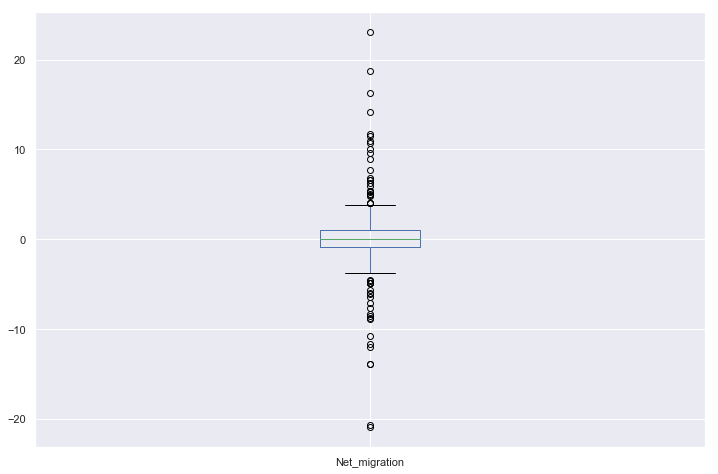

In [85]:
countries[['Net_migration']].boxplot()


* Note que não devemos remover da análise as observações consideradas _outliers_ segundo esse método.


**Agora, vamos utilizar a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`**

 Carregaremos as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


* Aplicaremos  `CountVectorizer` ao _data set_ `newsgroups` e descubriremos o número de vezes que a palavra _phone_ aparece no corpus.

In [86]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']

newsgroups = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

In [88]:
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(newsgroups.data)

In [95]:
num_phone = counts[:,count_vectorizer.vocabulary_['phone']].sum()
print('Número de vezes que a palavra phone aparece no corpus:',num_phone)

Número de vezes que a palavra phone aparece no corpus: 213


**Agora, apliquemos `TfidfVectorizer` ao _data set_ `newsgroups` e descubriremos o TF-IDF da palavra _phone_.** 

In [91]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectorizer.fit(newsgroups.data)

newsgroups_tfidf_vectorized = tfidf_vectorizer.transform(newsgroups.data)

In [93]:
TF_IDF = newsgroups_tfidf_vectorized[:,tfidf_vectorizer.vocabulary_['phone']].sum().round(3)
print('TF-IDF da palavra phone:',TF_IDF)

TF-IDF da palavra phone: 8.888
